# Preparations

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# Autocorr test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Autocorrelation analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARMA models
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL

In [2]:
!pip install pmdarima

# auto ARIMA
import pmdarima as pm
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00


In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [4]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# Data

We'll be analyzing closing stocks prices. Get data from [here](https://www.nasdaq.com/market-activity/stocks/tsla/historical?page=1&rows_per_page=10&timeline=y5).

Let's consider Tesla stocks- 5 years of data

In [5]:
tesla_data = pd.read_csv('tesla.csv', parse_dates=['Date'])

In [6]:
tesla_data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-12-04,$357.93,50810870,$353.00,$358.10,$348.60
1,2024-12-03,$351.42,58267200,$351.80,$355.69,$348.20
2,2024-12-02,$357.09,77986480,$352.38,$360.00,$351.1501
3,2024-11-29,$345.16,37167620,$336.08,$345.45,$334.6501
4,2024-11-27,$332.89,57896440,$341.80,$342.55,$326.59


Preprocessing data for comfortable work

In [7]:
tesla_data.rename(columns={'Date':'ds', 'Close/Last':'y'}, inplace=True)
tesla_data['y'] = tesla_data['y'].apply(lambda x: x[1:]).astype(float)

tesla_data = tesla_data[['ds','y']].sort_values(by='ds').set_index('ds')

In [8]:
tesla_data.head()

,y
ds,
2019-12-05,22.0247
2019-12-06,22.3927
2019-12-09,22.6353
2019-12-10,23.2560
2019-12-11,23.5133


Let's plot our data.

In [9]:
fig = px.line(tesla_data, x=tesla_data.index, y=tesla_data['y'],
              title="Tesla closing prices (daily)")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

# Stationarity

Let's analyze the stationarity of time series

### ADF test

In [10]:
adf_test(tesla_data['y'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.277415
p-value                           0.179355
#Lags Used                       10.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64


The defaults significance level is 5%.

<font color='red'>p-value > significance level </font>: : Fail to reject the null hypothesis H(0), the **time series is non-stationary**.

In [11]:
kpss_test(tesla_data['y'])

Results of KPSS Test:
Test Statistic            1.654784
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-4-71884a3c5bdd>:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The defaults significance level is 5%.

<font color='red'>p-value <= significance level </font>: Reject the null hypothesis H(0), **the time series is non-stationary**.

#Analyze autocorrelation

Analyze autocorrelation of the time series with Ljung-Box test and ACF, PACF.

### Ljung-Box

In [12]:
acorr_ljungbox(tesla_data['y'], return_df=True)

,lb_stat,lb_pvalue
1,1239.063075,1.976585e-271
2,2458.232555,0.000000e+00
3,3656.944330,0.000000e+00
4,4835.990542,0.000000e+00
5,5995.001643,0.000000e+00
6,7134.568126,0.000000e+00
7,8254.812288,0.000000e+00
8,9353.555963,0.000000e+00
9,10431.967024,0.000000e+00
10,11487.921863,0.000000e+00


The defaults significance level is 5%.

<font color='red'>p-value <= significance level</font>: Reject the null hypothesis H(0), **the time series is autocorrelated**.

### ACF and PACF

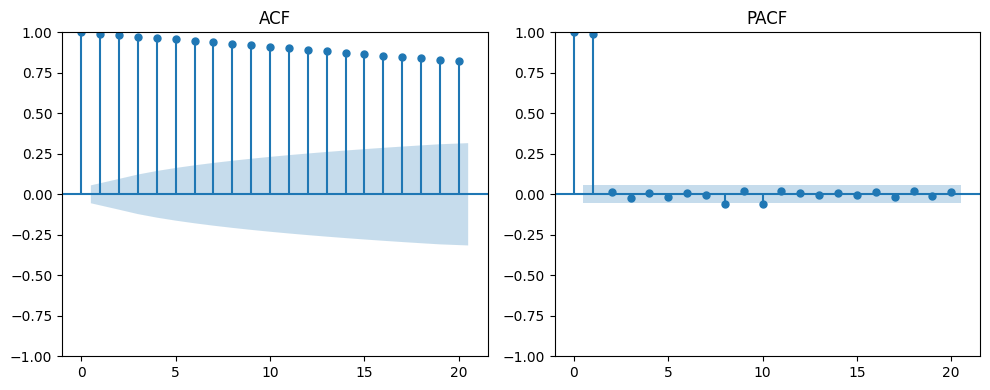

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(tesla_data['y'], ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(tesla_data['y'], ax=ax[1], lags=20)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

ACF decays slowly, it suggests autocorrelation. That's common in non-stationary series

PACF has 1 lags which is significant

# Make time series stationary

#### PCT chage

For financial data more efficient use PCT_Change method to reduction our time series to stationarity version.  We use percent change because better use it for financial data

In [14]:
tesla_data['pct_change'] = tesla_data['y'].pct_change()*100
tesla_data.head( )

,y,pct_change
ds,,
2019-12-05,22.0247,NaN
2019-12-06,22.3927,1.670851
2019-12-09,22.6353,1.083389
2019-12-10,23.2560,2.742177
2019-12-11,23.5133,1.106381


Let's see if percent change made the time series stationary.

In [15]:
fig = px.line(tesla_data, x=tesla_data.index, y=tesla_data['pct_change'],
              title="Teslat closing prices (daily) - pct_change")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

The data on plot looks more stationary

Let's check it by using ADF test

In [16]:
adf_test(tesla_data['pct_change'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -35.582841
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (1%)              -3.435567
Critical Value (5%)              -2.863844
Critical Value (10%)             -2.567997
dtype: float64


<font color='green'>**p-value <= significance level**</font> => we reject H(0) and **the time series is stationary**.

Let's also check on KPSS test

In [17]:
kpss_test(tesla_data['pct_change'].dropna())

Results of KPSS Test:
Test Statistic           0.500834
p-value                  0.041479
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


The defaults significance level is 5%.

<font color='red'>p-value <= significance level </font>: Reject the null hypothesis H(0), **the time series is non-stationary**.

Both tests reject H0 → results are contradictory

In [18]:
fig = px.line(tesla_data, x=tesla_data.index, y=tesla_data['y'],
              title="Tesla closing prices (daily)")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

# Decomposition

Let's try to learn which part includes our time series and make our residuals not autocorrelated

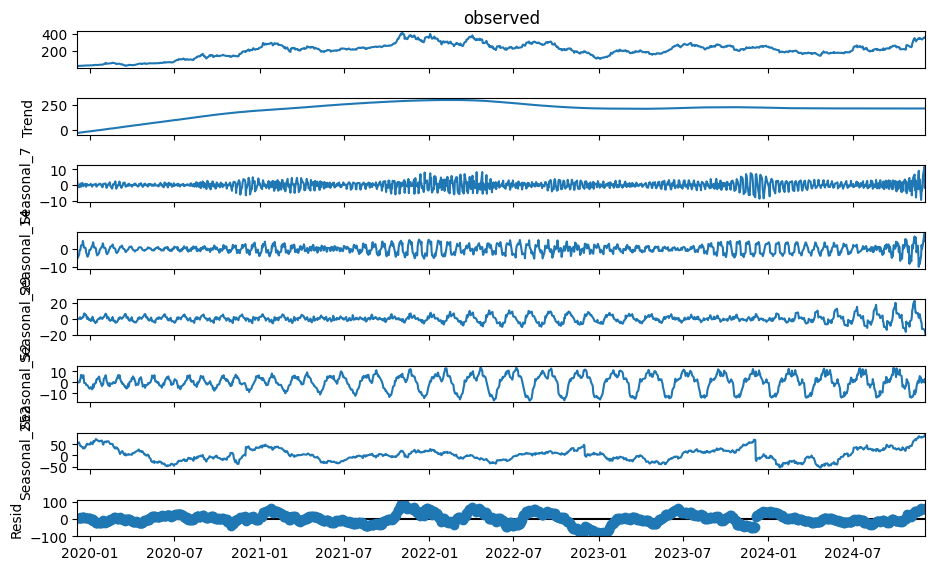

<Axes: xlabel='ds'>

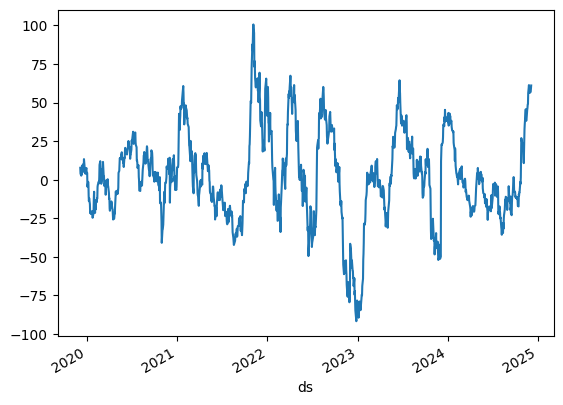

In [19]:
mstl = MSTL(tesla_data['y'], periods = (7, 14, 29, 52, 252))
res = mstl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()


res.resid.plot()

In [20]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,1207.915812,1.161387e-264
2,2364.910721,0.000000e+00
3,3466.552191,0.000000e+00
4,4512.235276,0.000000e+00
5,5499.591950,0.000000e+00
6,6428.252370,0.000000e+00
7,7295.451283,0.000000e+00
8,8106.462841,0.000000e+00
9,8863.151189,0.000000e+00
10,9558.178658,0.000000e+00


The defaults significance level is 5%.

<font color='red'>p-value <= significance level</font>: Reject the null hypothesis H(0), **the time series is autocorrelated on all lags**.

In [21]:
adf_test(res.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -4.949264
p-value                           0.000028
#Lags Used                       23.000000
Number of Observations Used    1234.000000
Critical Value (1%)              -3.435660
Critical Value (5%)              -2.863885
Critical Value (10%)             -2.568019
dtype: float64


<font color='green'>**p-value <= significance level**</font> => we reject H(0) and **the time series is stationary**.

Our actions are not succeed cause our residuals are still autorrelated

# ARMA in sample predition

Let's look at the ACF, PACF and AIC for choosing the right order for in sample predicting

## ACF and PACF

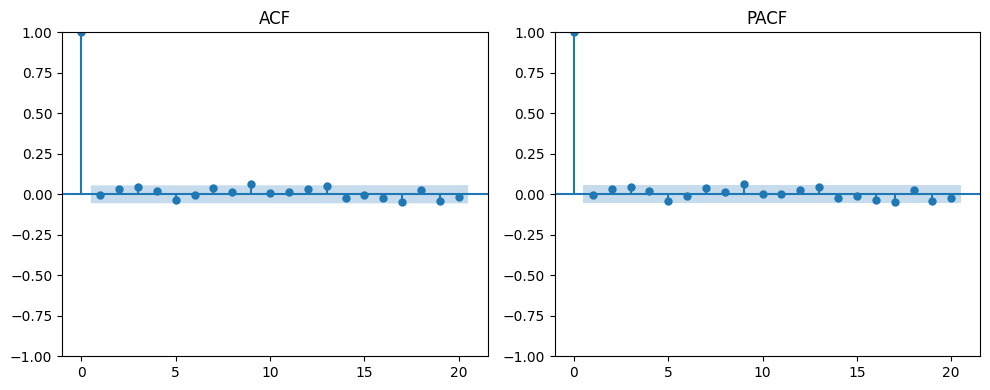

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(tesla_data['pct_change'].dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(tesla_data['pct_change'].dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

ACF plot tells us that we should choose p,q = (0, 0)

## AIC

In [23]:
tesla_pct = tesla_data['pct_change'].dropna()

In [24]:
best_params = []
for p in np.arange(0,7):
  for q in np.arange(0,7):
    model = ARIMA(tesla_pct, order=(p, 0, q)).fit()
    best_params.append({'p':p, 'q': q, 'AIC': model.aic, 'BIC': model.bic})

pd.DataFrame(best_params).sort_values(by="AIC").head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been prov

,p,q,AIC,BIC
40,5,5,7179.794181,7241.431980
23,3,2,7181.417804,7217.373187
17,2,3,7181.421648,7217.377031
18,2,4,7183.379541,7224.471407
24,3,3,7183.558799,7224.650665


:As we can see the smallest AIC ARIMA model has orders = (5, 0, 5)

In [25]:
model = ARIMA(tesla_pct, order=(5, 0, 5))

#Fit model
model = model.fit()

print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:             pct_change   No. Observations:                 1257
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -3577.897
Date:                Sat, 21 Dec 2024   AIC                           7179.794
Time:                        11:09:44   BIC                           7241.432
Sample:                             0   HQIC                          7202.959
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3167      0.160      1.978      0.048       0.003       0.630
ar.L1          0.4880      0.062      7.823      0.000       0.366       0.610
ar.L2         -0.6411      0.038    -17.046      0.0

As we can see all coefficients are significant

Now, let's check our residuals after ARIMA in-sample predicting

In [26]:
forecast = model.predict()

In [27]:
tesla_data['predict_pct'] = forecast

Let's look at the prediction on the plot

In [28]:
fig = px.line(title="Tesla closing prices (daily)_pct ")
fig.add_scatter(x=tesla_pct.index, y=tesla_pct, mode='lines', name='y_pct', line=dict(color='blue'))
fig.add_scatter(x=tesla_data['predict_pct'].index, y=tesla_data['predict_pct'], mode='lines', name='forecast_pct', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's return our data to initial:

In [29]:
y_0 = tesla_data['y'].iloc[0]
tesla_data['predict'] = tesla_data['y'].shift(1) * (1 + tesla_data['predict_pct']  / 100)

In [30]:
fig = px.line(title="Tesla closing prices (daily) ")
fig.add_scatter(x=tesla_data['y'].index, y=tesla_data['y'], mode='lines', name='y', line=dict(color='blue'))
fig.add_scatter(x=tesla_data['predict'].index, y=tesla_data['predict'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Use MAE for measure our prediction for models in this work cause result is absolute, easier to interpret because the errors are in the original units.

In [31]:
mae_in_sample_ARMA = np.mean(np.abs(tesla_data['y'] - tesla_data['predict']))
print(mae_in_sample_ARMA)

5.90085341837922


Delete some columns in tesla_data table. They don't need us anymore

In [32]:
tesla_data.drop(['predict_pct'], axis=1, inplace=True)
tesla_data.drop(['predict'], axis=1, inplace=True)

# ARMA out-of-sample predition

In [33]:
train_size = int(len(tesla_pct) * 0.98)
train_pct, test_pct = tesla_pct[:train_size], tesla_pct[train_size:]

In [34]:
fig = px.line(title="Tesla closing prices (daily) - pct")
fig.add_scatter(x=train_pct.index, y=train_pct, mode='lines', name='train_pct', line=dict(color='blue'))
fig.add_scatter(x=test_pct.index, y=test_pct, mode='lines', name='test_pct', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [35]:
# Instantiate the ARIMA(5, 0, 5) model
model = ARIMA(train_pct, order=(5, 0, 5))

# Fit the model
model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

Let's look how many points we need to predict

In [36]:
forecast_size = len(tesla_pct) - train_size

forecast_size

26

In [37]:
y_hat = model.get_forecast(steps=forecast_size)
y_hat = y_hat.predicted_mean
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test_pct.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



,predicted_mean
ds,
2024-10-29,0.407063
2024-10-30,1.130548
2024-10-31,-0.640457
2024-11-01,-0.335789
2024-11-04,1.431780
2024-11-05,0.406356
2024-11-06,0.464193
2024-11-07,0.446160
2024-11-08,-0.782731


In [38]:
fig = px.line(title="Tesla closing prices (daily) - pct")
fig.add_scatter(x=train_pct.index, y=train_pct.to_frame()['pct_change'], mode='lines', name='train_pct', line=dict(color='blue'))
fig.add_scatter(x=test_pct.index, y=test_pct.to_frame()['pct_change'], mode='lines', name='test_pct', line=dict(color='green'))
fig.add_scatter(x=y_hat.index, y=y_hat['predicted_mean'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Finally, let's reverse our time series and the forecast to the original scales.

In [39]:
tesla_data['predict_pct'] = y_hat['predicted_mean']

In [40]:
tesla_data

,y,pct_change,predict_pct
ds,,,
2019-12-05,22.0247,NaN,NaN
2019-12-06,22.3927,1.670851,NaN
2019-12-09,22.6353,1.083389,NaN
2019-12-10,23.2560,2.742177,NaN
2019-12-11,23.5133,1.106381,NaN
...,...,...,...
2024-11-27,332.8900,-1.578807,1.309488
2024-11-29,345.1600,3.685902,-0.167850
2024-12-02,357.0900,3.456368,-0.131587


Back our predicted data to initial scale

In [41]:
y_0 = tesla_data['y'][train_size-1]
tesla_data['pred'] = tesla_data['y'][train_size:].shift(1) * (1 + tesla_data['predict_pct'] / 100)

<ipython-input-41-00bbf1fc26d3>:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Let's plot our prediction

In [42]:
fig = px.line(title="Tesla closing prices (daily) ")
fig.add_scatter(x=tesla_data[:train_size].index, y=tesla_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=tesla_data[train_size:].index, y=tesla_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=tesla_data.index, y=tesla_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's measure our results of in-sample prediction by using metric MDAPE cause it's scale-independent and not sensitive to outliers

In [43]:
mae_out_sample_ARMA = np.mean(np.abs(tesla_data['y'][train_size:] - tesla_data['pred']))
print(mae_out_sample_ARMA)

11.194880159238506


Delete some columns in tesla_data table. They don't need us anymore

In [44]:
tesla_data.drop(['predict_pct'], axis=1, inplace=True)
tesla_data.drop(['pred'], axis=1, inplace=True)

# ARIMA in-sample predition

We need to find right order for p, d, q

Firstly, let's try to find d by differencing initial until it becomes stationary

In [45]:
tesla_data['diff'] = tesla_data['y'].diff()

Let's see if percent change made the time series stationary.

In [46]:
fig = px.line(tesla_data, x=tesla_data.index, y=tesla_data['diff'],
              title="Tesla closing prices (daily) - diff")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Plot looks stationary

Let's check it by using ADF, KPSS tests

In [47]:
adf_test(tesla_data['diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.034622e+01
p-value                        2.606866e-18
#Lags Used                     9.000000e+00
Number of Observations Used    1.247000e+03
Critical Value (1%)           -3.435605e+00
Critical Value (5%)           -2.863861e+00
Critical Value (10%)          -2.568005e+00
dtype: float64


<font color='green'>**p-value <= significance level**</font> => we reject H(0) and **the time series is stationary**.

Now, we need to find right order for the p, q. Let's look at the ACF, PACF and AIC, BIC

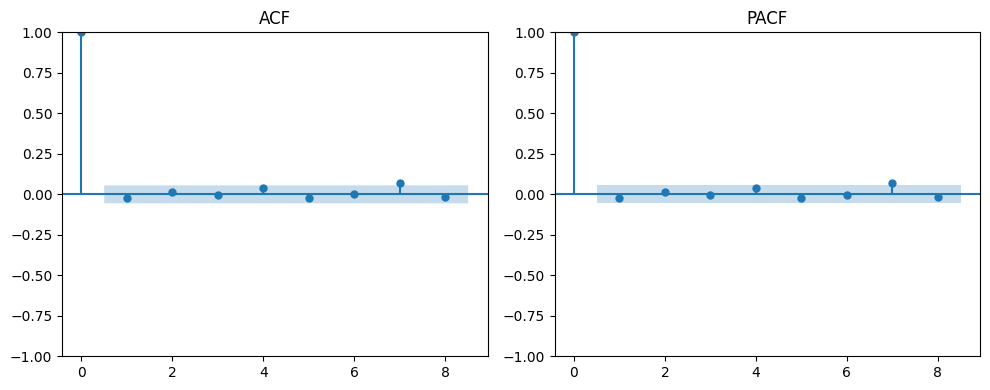

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(tesla_data['diff'].dropna(), ax=ax[0], lags=8)
ax[0].set_title('ACF')

# PACF
plot_pacf(tesla_data['diff'].dropna(), ax=ax[1], lags=8)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

ACF, PACF plot tells us that we should choose p,q = (0, 0) cause we don't have significant lags

In [49]:
tesla_diff = tesla_data['diff'].dropna()

In [50]:
best_params = []
for p in np.arange(0,7):
  for q in np.arange(0,7):
    model = ARIMA(tesla_diff, order=(p, 0, q)).fit()
    best_params.append({'p':p, 'q': q, 'AIC': model.aic, 'BIC': model.bic})

pd.DataFrame(best_params).sort_values(by="AIC").head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been prov

,p,q,AIC,BIC
16,2,2,8957.286592,8988.105491
25,3,4,8957.934831,9004.163180
37,5,2,8960.746672,9006.975021
19,2,5,8960.793003,9007.021352
32,4,4,8961.895398,9013.260230


As we can see the order (2, 1, 2)

So we're ready to predict in-sample ARIMA model

In [51]:
model = ARIMA(tesla_data['y'], order=(2,1,2))

#Fit model
model = model.fit()

print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4473.261
Date:                Sat, 21 Dec 2024   AIC                           8956.523
Time:                        11:12:30   BIC                           8982.205
Sample:                             0   HQIC                          8966.175
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6785      0.023    -72.983      0.000      -1.724      -1.633
ar.L2         -0.9469      0.022    -42.990      0.000      -0.990      -0.904
ma.L1          1.6690      0.022     77.085      0.0

Only constant is not significant

In [52]:
forecast = model.predict()

In [53]:
tesla_data['pred'] = forecast

Let's look at the prediction on the plot

In [54]:
fig = px.line(title="Tesla closing prices (daily)")
fig.add_scatter(x=tesla_data['y'].index, y=tesla_data['y'], mode='lines', name='y', line=dict(color='blue'))

fig.add_scatter(x=tesla_data['pred'].index, y=tesla_data['pred'], mode='lines', name='predict', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [55]:
mae_in_sample_ARIMA = np.mean(np.abs(tesla_data['y'] - tesla_data['pred']))
print(mae_in_sample_ARIMA)

5.8871992676720275


So we don't need anymore some columns. We can delete its

In [56]:
tesla_data.drop('pred', axis=1, inplace=True)

# ARIMA out-of-sample predition

In [57]:
train_size = int(len(tesla_data) * 0.95)
train, test = tesla_data['y'][:train_size], tesla_data['y'][train_size:]

In [58]:
forecast_size = len(tesla_data) - train_size

forecast_size

63

In [59]:
fig = px.line(title="Tesla closing prices (daily)")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's make prediction by using ARIMA model and order (2, 1, 2) which we found earlier as the best choice for AIC and BIC

In [60]:
model = ARIMA(train, order=(2, 1, 2))

#Fit model
model = model.fit()

print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1195
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4222.198
Date:                Sat, 21 Dec 2024   AIC                           8454.397
Time:                        11:12:31   BIC                           8479.822
Sample:                             0   HQIC                          8463.977
                               - 1195                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      5.207     -0.059      0.953     -10.513       9.898
ar.L2          0.1636      3.382      0.048      0.961      -6.465       6.793
ma.L1          0.2792      5.209      0.054      0.9

Only sigma2 is significant

In [61]:
y_hat = model.get_forecast(steps=forecast_size)
y_hat = y_hat.predicted_mean
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



,predicted_mean
ds,
2024-09-06,230.129110
2024-09-09,230.235343
2024-09-10,230.195982
2024-09-11,230.225464
2024-09-12,230.209959
...,...
2024-11-27,230.216125
2024-11-29,230.216125
2024-12-02,230.216125


In [73]:
tesla_data['forecast'] = y_hat['predicted_mean']

In [63]:
tesla_data

,y,pct_change,diff,forecast
ds,,,,
2019-12-05,22.0247,NaN,NaN,NaN
2019-12-06,22.3927,1.670851,0.3680,NaN
2019-12-09,22.6353,1.083389,0.2426,NaN
2019-12-10,23.2560,2.742177,0.6207,NaN
2019-12-11,23.5133,1.106381,0.2573,NaN
...,...,...,...,...
2024-11-27,332.8900,-1.578807,-5.3400,230.216125
2024-11-29,345.1600,3.685902,12.2700,230.216125
2024-12-02,357.0900,3.456368,11.9300,230.216125


In [74]:
fig = px.line(title="Tesla closing prices (daily)")
fig.add_scatter(x=tesla_data[:train_size].index, y=tesla_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=tesla_data[train_size:].index, y=tesla_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=tesla_data.index, y=tesla_data['forecast'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [75]:
mae_out_of_sample_ARIMA = np.mean(np.abs(tesla_data['y'] - tesla_data['forecast']))
print(mae_out_of_sample_ARIMA)

43.867973654930836


Delete some columns in the table. They don't need us anymore

In [77]:
tesla_data.drop(['forecast'], axis=1, inplace=True)

# ADD Regressors

Let's add regressors:

**DUMMY REGRESSORS:**
1. Covid affects on Tesla company. Tesla is forced to put most of its employees on unpaid leave for the duration of the quarantine. Link: [News](https://tsk.ua/news/glavnye-novosti-tesla-nedeli-ot-tsk/)

2. The deal for Elon Musk to buy Twitter is October 2022. While not directly related to Tesla, it's obvious from the company's stock price.

**CONTINUOUS REGRESSORS:**
1. income as factor which influece more than others as usual

### Dummy regressors

In [108]:
date_range = pd.date_range(start=tesla_data.index.min(), end=tesla_data.index.max())

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

In [109]:
covid_start = "2020-01-01"
covid_end = "2023-05-05"
post_covid_end = "2025-05-05"

buy_start = "2022-10-01"
buy_end = "2022-11-01"

In [110]:
# COVID periods

# Mark the COVID and post-COVID dates with 1 and other dates with 0
regressors['covid'] = ((regressors['ds'] >= covid_start) \
                            & (regressors['ds'] <= covid_end)).astype(int)
regressors['post_covid'] = ((regressors['ds'] >= covid_end) \
                            & (regressors['ds'] <= post_covid_end)).astype(int)

regressors['buy_twitter'] = ((regressors['ds'] >= buy_start) \
                            & (regressors['ds'] <= buy_end)).astype(int)

regressors = regressors[~regressors['ds'].dt.weekday.isin([5, 6])] # remove weekends
regressors.set_index('ds', inplace=True)

regressors = regressors.join(tesla_data)[['covid', 'post_covid', 'buy_twitter']] # there're several nulls in stocks
regressors = pd.DataFrame(regressors)

regressors

,covid,post_covid,buy_twitter
ds,,,
2019-12-05,0,0,0
2019-12-06,0,0,0
2019-12-09,0,0,0
2019-12-10,0,0,0
2019-12-11,0,0,0
...,...,...,...
2024-11-28,0,1,0
2024-11-29,0,1,0
2024-12-02,0,1,0


In [111]:
fig = px.line(title="Dummy regressor")
fig.add_scatter(x=regressors['covid'].index, y=regressors['covid'], mode='lines', name='covid', line=dict(color='blue'))
fig.add_scatter(x=regressors['post_covid'].index, y=regressors['post_covid'], mode='lines', name='post-COVID for forecast', line=dict(color='green'))
fig.add_scatter(x=regressors['buy_twitter'].index, y=regressors['buy_twitter'], mode='lines', name='Buying Twitter', line=dict(color='pink'))


fig.update_layout(template='plotly_white', width=1000, height=400)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

### Continuous regressors

[Here we can find information about Tesla's income](https://www.macrotrends.net/stocks/charts/TSLA/tesla/operating-income)

In [112]:
net_income = pd.read_csv('net_income_tesla.csv', sep=';', parse_dates=['quarter'])
net_income.rename(columns={'quarter':'ds', 'net_income (in millions of USD)':'x'}, inplace=True)
net_income['x'] = net_income['x'].apply(lambda x: x[1:].replace(',','')).astype(float)
net_income = net_income[['ds','x']].sort_values(by='ds').set_index('ds')
net_income

<ipython-input-112-510d9428866d>:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,x
ds,
2019-09-30,261.0
2019-12-31,359.0
2020-03-31,16.0
2020-06-30,104.0
2020-09-30,300.0
2020-12-31,270.0
2021-03-31,438.0
2021-06-30,1142.0
2021-09-30,1618.0


In [113]:
date_range = pd.date_range(start=tesla_data.index.min(), end=tesla_data.index.max())

# Create the DataFrame
net_income_daily = pd.DataFrame(date_range, columns=["ds"])

regressors = regressors.join(net_income, how='outer').fillna(method='ffill').loc[regressors.index.min():regressors.index.max()][['covid', 'post_covid', 'buy_twitter', 'x']]


regressors

<ipython-input-113-9f04a420c7c1>:6: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,covid,post_covid,buy_twitter,x
ds,,,,
2019-12-05,0.0,0.0,0.0,261.0
2019-12-06,0.0,0.0,0.0,261.0
2019-12-09,0.0,0.0,0.0,261.0
2019-12-10,0.0,0.0,0.0,261.0
2019-12-11,0.0,0.0,0.0,261.0
...,...,...,...,...
2024-11-28,0.0,1.0,0.0,2167.0
2024-11-29,0.0,1.0,0.0,2167.0
2024-12-02,0.0,1.0,0.0,2167.0


Удалим строки в таблице regressors, которые не пересекаются с основной таблицей

In [114]:
len(regressors)

1310

In [115]:
len(tesla_data['y'])

1258

In [116]:
rows_to_drop = regressors.index.difference(tesla_data.index)
regressors.drop(rows_to_drop, inplace=True)

# ARIMAX in-sample prediction

Use the order=(2, 1, 2) which we found out earlier

In [117]:
model = ARIMA(tesla_data['y'], exog=regressors[['covid', 'post_covid', 'buy_twitter','x']], order=(2, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4479.369
Date:                Sat, 21 Dec 2024   AIC                           8976.738
Time:                        11:14:37   BIC                           9022.966
Sample:                             0   HQIC                          8994.112
                               - 1258                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid          -0.4673     41.896     -0.011      0.991     -82.583      81.648
post_covid      8.8600   1213.438      0.007      0.994   -2369.436    2387.156
buy_twitter    -5.0030      2.932     -1.706    

Only sigma2 is statistically significant

In [118]:
forecast = model_fit.predict()

In [119]:
tesla_data['pred'] = forecast

Let's compare plots

In [120]:
fig = px.line(title="Tesla closing prices (daily)")
fig.add_scatter(x=tesla_data.index, y=tesla_data['y'], mode='lines', name='y', line=dict(color='blue'))
fig.add_scatter(x=tesla_data.index, y=tesla_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Check residuals after prediction

In [121]:
residuals = tesla_data['y'] - tesla_data['pred']

In [122]:
residuals.mean()

0.27963833780391417

Good, the mean of residuals aroud 0

In [123]:
mae_in_sample_ARIMA_x = np.mean(np.abs(tesla_data['y'] - tesla_data['pred']))
print(mae_in_sample_ARIMA_x)

5.910596496433795


So we don't need anymore some columns. We can delete its

In [124]:
tesla_data.drop('pred', axis=1, inplace=True)

# ARIMAX out-of-sample prediction

In [125]:
train_size = int(len(tesla_data) * 0.95)
train, test = tesla_data['y'][:train_size], tesla_data['y'][train_size:]

In [126]:
forecast_size = len(tesla_data) - train_size

forecast_size

63

In [127]:
fig = px.line(title="Tesla closing prices (daily) ")
fig.add_scatter(x=tesla_data[:train_size].index, y=tesla_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=tesla_data[train_size:].index, y=tesla_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [141]:
model = ARIMA(train, exog=regressors[:train_size][['covid', 'post_covid', 'buy_twitter','x']], order=(2, 1, 2)) # no need to add I, since the original y was already differenced.
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1195
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4221.273
Date:                Sat, 21 Dec 2024   AIC                           8460.547
Time:                        11:26:14   BIC                           8506.312
Sample:                             0   HQIC                          8477.791
                               - 1195                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid          -0.4673     40.263     -0.012      0.991     -79.382      78.447
post_covid      8.8600   1039.655      0.009      0.993   -2028.826    2046.547
buy_twitter    -5.0045      2.768     -1.808    

Only sigma2 is significant

In [155]:
forecast = model_fit.predict(n_periods=forecast_size, start=len(test), end=len(test) + forecast_size - 1, exog = regressors[['covid', 'post_covid', 'buy_twitter','x']][train_size:])

In [156]:
forecast = pd.DataFrame(forecast)
forecast['ds'] = test.index
forecast.set_index('ds', inplace=True)
forecast.columns = ['y_hat']
display(forecast)

,y_hat
ds,
2024-09-06,46.890504
2024-09-09,40.708944
2024-09-10,42.819357
2024-09-11,42.417350
2024-09-12,37.432172
...,...
2024-11-27,55.593874
2024-11-29,59.802862
2024-12-02,58.865040


In [131]:
tesla_data['pred'] = forecast

In [132]:
fig = px.line(title="Tesla closing prices (daily) ")
fig.add_scatter(x=tesla_data[:train_size].index, y=tesla_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=tesla_data[train_size:].index, y=tesla_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=tesla_data.index, y=tesla_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Look at the residuals

In [133]:
residuals = tesla_data['y'] - tesla_data['pred']

In [134]:
residuals.mean()

224.0207840388174

Let's try to add this to prediction

In [135]:
tesla_data['pred'] = tesla_data['pred'] + residuals.mean()

In [136]:
residuals = tesla_data['y'] - tesla_data['pred']

In [137]:
residuals.mean()

1.3985285592738479e-14

In [138]:
fig = px.line(title="Tesla closing prices (daily) ")
fig.add_scatter(x=tesla_data[:train_size].index, y=tesla_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=tesla_data[train_size:].index, y=tesla_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=tesla_data.index, y=tesla_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [139]:
mae_out_of_sample_ARIMA_x = np.mean(np.abs(tesla_data['y'] - tesla_data['pred']))
print(mae_out_of_sample_ARIMA_x)

35.33976584310812


# Comparing metrics

In [140]:
print("ARMA (pct) in-sample: ", mae_in_sample_ARMA)
print("ARMA (pct) out-of-sample: ", mae_out_sample_ARMA)
print("ARIMA in-sample: ", mae_in_sample_ARIMA)
print("ARIMA out-of-sample: ", mae_out_of_sample_ARIMA)
print("ARIMAX in-sample: ", mae_in_sample_ARIMA_x)
print("ARIMAX out-of-sample: ", mae_out_of_sample_ARIMA_x)

ARMA (pct) in-sample:  5.90085341837922
ARMA (pct) out-of-sample:  11.194880159238506
ARIMA in-sample:  5.8871992676720275
ARIMA out-of-sample:  43.867973654930836
ARIMAX in-sample:  5.910596496433795
ARIMAX out-of-sample:  35.33976584310812


The best result came from ARMA

The worst result came from ARIMAX